In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append(str(Path("..").resolve()))
from ast import literal_eval
from sdm import visualize_skillcorner as vsc
from sdm import visualize_features as vf
from IPython.display import HTML
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import os
from functools import partial
from sdm import visualize_features as vf
from unxpass.datasets import PassesDataset
from unxpass.components.withSpeeds import pass_selection_speeds, pass_value_speeds
import mlflow
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
ball_ff = pd.read_parquet("/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/feats/x_ball_freeze_frame.parquet")
gk_ff = pd.read_parquet("/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/feats/x_gk_frame.parquet")
player_ff = pd.read_parquet("/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/feats/x_player_freeze_frame.parquet")

scores_xg = pd.read_parquet("/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/feats/y_scores_xg.parquet")

In [83]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68
GOAL_WIDTH = 7.32
GOAL_CENTER_Y = PITCH_WIDTH / 2.0
HALF_GOAL = GOAL_WIDTH / 2.0

GOAL_X = PITCH_LENGTH

LEFT_POST_Y = GOAL_CENTER_Y - HALF_GOAL
RIGHT_POST_Y = GOAL_CENTER_Y + HALF_GOAL
def _safe_min(arr):
    arr = arr[~np.isnan(arr)]
    return float(arr.min()) if arr.size > 0 else np.nan

def _euclidean_distance(x1, y1, x2, y2):
    """ Distance between two points """
    dx = x2 - x1
    dy = y2 - y1
    return float(np.hypot(dx, dy))


def _angle_between_points(x_from, y_from, x_to, y_to):
    """ Angle (in radians) from (x_from, y_from) to (x_to, y_to) """
    return float(np.arctan2(y_to - y_from, x_to - x_from))


def _wrap_angle_diff(a, b):
    """
    Smallest signed difference between two angles a and b (radians),
    wrapped into [-pi, pi].
    """
    diff = a - b
    return float(np.arctan2(np.sin(diff), np.cos(diff)))


def compute_shot_angle_from_ball(
    ball_x,
    ball_y,
):
    """
    Hypothetical shot angle at the ball: angle between rays ball→left_post and ball→right_post.
    Returns radians in [0, pi].
    """

    angle_left = _angle_between_points(ball_x, ball_y, GOAL_X, LEFT_POST_Y)
    angle_right = _angle_between_points(ball_x, ball_y, GOAL_X, RIGHT_POST_Y)
    shot_angle = abs(_wrap_angle_diff(angle_right, angle_left))
    return shot_angle

def compute_gk_feats(ball_ff, player_ff, gk_ff):
    """ Computes all features relating to the goalkeeper"""
    gk_x = float(gk_ff["gk_frame_x"])
    gk_y = float(gk_ff["gk_frame_y"])


    ball_x = float(ball_ff["ball_freeze_frame_x"])
    ball_y = float(ball_ff["ball_freeze_frame_y"])

    gk_dist_to_goal = _euclidean_distance(gk_x, gk_y, GOAL_X, GOAL_CENTER_Y)
    gk_dist_to_ball = _euclidean_distance(gk_x, gk_y, ball_x, ball_y)

    gk_depth = GOAL_X - gk_x 

    angle_ball_to_gk = _angle_between_points(ball_x, ball_y, gk_x, gk_y)

    angle_ball_to_goal_center = _angle_between_points(ball_x, ball_y, GOAL_X, GOAL_CENTER_Y)
    angle_diff = _wrap_angle_diff(angle_ball_to_gk, angle_ball_to_goal_center)
    

    gk_lateral_offset = gk_y - GOAL_CENTER_Y

    xs, ys, in_possession, detected = [], [], [], []
    dist_to_ball, dist_to_gk = [], []

    vxs, vys = [], []

    for p in player_ff[0]:
        if p.get("opp_gk", False):
            continue

        det = bool(p.get("is_detected", False))
        detected.append(det)
        in_possession.append(bool(p.get("in_possession", False)))

        if not det:
            xs.append(np.nan)
            ys.append(np.nan)
            dist_to_ball.append(np.nan)
            dist_to_gk.append(np.nan)
            vxs.append(0.0)
            vys.append(0.0)
            continue

        x = float(p["x"])
        y = float(p["y"])
        xs.append(x)
        ys.append(y)
        dist_to_gk.append(_euclidean_distance(x, y, gk_x, gk_y))
        dist_to_ball.append(_euclidean_distance(x, y, ball_x, ball_y))

        vxs.append(float(p.get("x_velo", 0.0)))
        vys.append(float(p.get("y_velo", 0.0)))

    xs = np.asarray(xs, dtype=float) if xs else np.array([])
    ys = np.asarray(ys, dtype=float) if ys else np.array([])
    in_possession = np.asarray(in_possession, dtype=bool) if in_possession else np.array([], dtype=bool)
    detected = np.asarray(detected, dtype=bool) if detected else np.array([], dtype=bool)
    dist_to_ball = np.asarray(dist_to_ball, dtype=float) if dist_to_ball else np.array([])
    dist_to_gk = np.asarray(dist_to_gk, dtype=float) if dist_to_gk else np.array([])
    
    vxs = np.asarray(vxs, dtype=float) if vxs else np.array([])
    vys = np.asarray(vys, dtype=float) if vys else np.array([])

    def_mask = (~in_possession & detected) if detected.size else np.array([], dtype=bool)

    nearest_defender_to_gk = _safe_min(dist_to_gk[def_mask]) if dist_to_gk.size else np.nan
    

    # 2) Pressure on GK
    defenders_dist_gk = dist_to_gk[def_mask] if dist_to_gk.size else np.array([])

    num_def_within_3m_gk = int((defenders_dist_gk <= 3.0).sum()) if defenders_dist_gk.size else 0




    return {
        "gk_x": gk_x,
        "gk_y": gk_y,
        "gk_dist_to_goal_center": gk_dist_to_goal,
        "gk_dist_to_ball": gk_dist_to_ball,
        "angle_ball_to_goal_center": angle_ball_to_goal_center,
        "angle_ball_to_gk": angle_ball_to_gk,
        "angle_diff_gk_vs_goal_center_from_ball": angle_diff,
        "gk_depth": gk_depth,
        "gk_lateral_offset_from_center": gk_lateral_offset,
        "nearest_defender_to_gk": nearest_defender_to_gk,
        "num_def_within_3m_gk": num_def_within_3m_gk,
    }

def compute_geometry_features(ball_ff, gk_ff):
    """
    Geometry-only features from ball & GK freeze-frames.
    Assumes keys:
      ball_ff: 'ball_freeze_frame_x', 'ball_freeze_frame_y'
      gk_ff:   'gk_frame_x', 'gk_frame_y'
    """
    ball_x = float(ball_ff["ball_freeze_frame_x"])
    ball_y = float(ball_ff["ball_freeze_frame_y"])
    

    ball_dist_to_goal = _euclidean_distance(ball_x, ball_y, GOAL_X, GOAL_CENTER_Y)
    

    shot_angle = compute_shot_angle_from_ball(
        ball_x, ball_y
    )

    ball_lateral_offset = ball_y - GOAL_CENTER_Y
    

    return {
        "ball_x": ball_x,
        "ball_y": ball_y,
        "ball_dist_to_goal_center": ball_dist_to_goal,
        "shot_angle": shot_angle,
        "ball_lateral_offset_from_center": ball_lateral_offset,
    }
def compute_ball_features(ball_ff):
    """
    Features using only ball_ff: position, height, velocity, speed, direction.
    """
    bz = float(ball_ff.get("z", 0.0))
    vx = float(ball_ff.get("ball_freeze_frame_x_velo", 0.0))
    vy = float(ball_ff.get("ball_freeze_frame_y_velo", 0.0))

    speed = float(np.hypot(vx, vy))
    direction = float(np.arctan2(vy, vx)) if speed > 1e-6 else 0.0

    return {
        "ball_z": bz,
        "ball_vx": vx,
        "ball_vy": vy,
        "ball_speed": speed,
        "ball_direction": direction, 
    }



def compute_player_context_features(
    ball_ff,
    gk_ff,
    player_ff,
    pitch_length=105.0,
    pitch_width=68.0,
    goal_width=7.32,
    defending_goal="right",
):
    """
    Player-context features using only player_ff plus ball/gk for distances.
    player_ff is iterable of dict-like items with keys:
      'in_possession', 'is_detected', 'opp_gk', 'player_id', 'x', 'y', 'x_velo', 'y_velo'
    """
    ball_x = float(ball_ff["ball_freeze_frame_x"])
    ball_y = float(ball_ff["ball_freeze_frame_y"])

    goal_center_y = pitch_width / 2.0

    xs, ys, in_possession, detected = [], [], [], []
    dist_to_ball, dist_to_gk = [], []

    vxs, vys = [], []

    for p in player_ff[0]:
        if p.get("opp_gk", False):
            continue

        det = bool(p.get("is_detected", False))
        detected.append(det)
        in_possession.append(bool(p.get("in_possession", False)))

        if not det:
            xs.append(np.nan)
            ys.append(np.nan)
            dist_to_ball.append(np.nan)
            dist_to_gk.append(np.nan)
            vxs.append(0.0)
            vys.append(0.0)
            continue

        x = float(p["x"])
        y = float(p["y"])
        xs.append(x)
        ys.append(y)

        dist_to_ball.append(_euclidean_distance(x, y, ball_x, ball_y))

        vxs.append(float(p.get("x_velo", 0.0)))
        vys.append(float(p.get("y_velo", 0.0)))

    xs = np.asarray(xs, dtype=float) if xs else np.array([])
    ys = np.asarray(ys, dtype=float) if ys else np.array([])
    in_possession = np.asarray(in_possession, dtype=bool) if in_possession else np.array([], dtype=bool)
    detected = np.asarray(detected, dtype=bool) if detected else np.array([], dtype=bool)
    dist_to_ball = np.asarray(dist_to_ball, dtype=float) if dist_to_ball else np.array([])
    
    vxs = np.asarray(vxs, dtype=float) if vxs else np.array([])
    vys = np.asarray(vys, dtype=float) if vys else np.array([])

    num_players_total = len(player_ff)
    num_detected_players = int(detected.sum()) if detected.size else 0
    num_possession_players = int((in_possession & detected).sum()) if detected.size else 0
    num_defending_players = num_detected_players - num_possession_players

    atk_mask = (in_possession & detected) if detected.size else np.array([], dtype=bool)
    def_mask = (~in_possession & detected) if detected.size else np.array([], dtype=bool)


    nearest_attacker_to_ball = _safe_min(dist_to_ball[atk_mask]) if dist_to_ball.size else np.nan
    nearest_defender_to_ball = _safe_min(dist_to_ball[def_mask]) if dist_to_ball.size else np.nan
    

    box_x_min = PITCH_LENGTH - 20.0
    box_x_max = PITCH_LENGTH


    in_box = (
        (xs >= box_x_min)
        & (xs <= box_x_max)
        & (np.abs(ys - goal_center_y) <= goal_width)
        & detected
    )

    num_attackers_in_box = int((in_box & atk_mask).sum()) if in_box.size else 0
    num_defenders_in_box = int((in_box & def_mask).sum()) if in_box.size else 0

    # ---------- NEW FEATURES ----------

    # 1) Defensive pressure on the ball
    defenders_dist_ball = dist_to_ball[def_mask] if dist_to_ball.size else np.array([])
    num_def_within_2m_ball = int((defenders_dist_ball <= 2.0).sum()) if defenders_dist_ball.size else 0
    num_def_within_5m_ball = int((defenders_dist_ball <= 5.0).sum()) if defenders_dist_ball.size else 0



    # 3) Defensive line height / compactness
    def_xs = xs[def_mask] if xs.size else np.array([])
    def_ys = ys[def_mask] if ys.size else np.array([])

    if def_xs.size > 0:
        last_defender_x = float(def_xs.max())
        first_defender_x = float(def_xs.min())
        defensive_line_depth = pitch_length - last_defender_x
        defensive_width = float(def_ys.max() - def_ys.min())
        defensive_y_std = float(def_ys.std())
    else:
        last_defender_x = np.nan
        first_defender_x = np.nan
        defensive_line_depth = np.nan
        defensive_width = np.nan
        defensive_y_std = np.nan

    six_depth = 5.5
    six_width = 18.32
    half_six_width = six_width / 2.0
    six_y_min = GOAL_CENTER_Y - half_six_width
    six_y_max = GOAL_CENTER_Y + half_six_width

    six_x_min = pitch_length - six_depth
    six_x_max = pitch_length


    in_six = (
        (xs >= six_x_min)
        & (xs <= six_x_max)
        & (ys >= six_y_min)
        & (ys <= six_y_max)
        & detected
    )

    num_attackers_in_six = int((in_six & atk_mask).sum()) if in_six.size else 0

    # 5) Attackers behind defensive line (if we have a line)
    if def_xs.size > 0:
        attackers_behind_line = int((xs[atk_mask & detected] > last_defender_x).sum())
    else:
        attackers_behind_line = 0

    # 6) Team centroids and distances to GK
    if atk_mask.any():
        atk_xs = xs[atk_mask & detected]
        atk_ys = ys[atk_mask & detected]
        atk_centroid_x = float(atk_xs.mean())
        atk_centroid_y = float(atk_ys.mean())
    else:
        atk_centroid_x = atk_centroid_y = np.nan

    if def_mask.any():
        def_cx = float(def_xs.mean())
        def_cy = float(def_ys.mean())
    else:
        def_cx = def_cy = np.nan

    return {
        # original features
        "num_players_total": num_players_total,
        "num_detected_players": num_detected_players,
        "num_possession_players": num_possession_players,
        "num_defending_players": num_defending_players,
        "nearest_attacker_to_ball": nearest_attacker_to_ball,
        "nearest_defender_to_ball": nearest_defender_to_ball,
        "num_attackers_in_box": num_attackers_in_box,
        "num_defenders_in_box": num_defenders_in_box,

        # new: pressure
        "num_def_within_2m_ball": num_def_within_2m_ball,
        "num_def_within_5m_ball": num_def_within_5m_ball,

        # new: defensive structure
        "last_defender_x": last_defender_x,
        "first_defender_x": first_defender_x,
        "defensive_line_depth": defensive_line_depth,
        "defensive_width": defensive_width,
        "defensive_y_std": defensive_y_std,

        # new: threat near goal
        "num_attackers_in_six": num_attackers_in_six,
        "attackers_behind_line": attackers_behind_line,

        # new: centroids
        "atk_centroid_x": atk_centroid_x,
        "atk_centroid_y": atk_centroid_y,
        "def_centroid_x": def_cx,
        "def_centroid_y": def_cy,
    }


def build_frame_features(ball_ff,
                         gk_ff,
                         player_ff,
                         pitch_length=103.0,
                         pitch_width=68.0,
                         goal_width=7.32,
                         defending_goal="right"):
    """
    High-level pipeline: given ball_ff, gk_ff, player_ff for a frame,
    return features
    """
    feats = {}

    geom = compute_geometry_features(
        ball_ff, gk_ff
    )
    feats.update(geom)

    ball_feats = compute_ball_features(ball_ff)
    feats.update(ball_feats)

    gk_feats = compute_gk_feats(ball_ff, player_ff, gk_ff)
    feats.update(gk_feats)

    player_ctx = compute_player_context_features(
        ball_ff, gk_ff, player_ff
    )
    feats.update(player_ctx)

    return feats




feature_rows = []
for idx in tqdm(ball_ff.index): 
    ball_ff_i = ball_ff.loc[idx]
    gk_ff_i = gk_ff.loc[idx]
    player_ff_i = player_ff.loc[idx] 
    feature_rows.append(build_frame_features(ball_ff_i, gk_ff_i, player_ff_i))

features = pd.DataFrame(feature_rows)

  2%|▏         | 3559/232450 [00:02<02:24, 1578.58it/s]


KeyboardInterrupt: 

In [ ]:
features.index = scores_xg.index

data = pd.merge(features, scores_xg, left_index = True, right_index = True)

In [85]:
X = data.drop(columns=['scores_xg'])
y = data['scores_xg']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    n_jobs=-1,
    tree_method="hist",   # or "gpu_hist" if you have GPU
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="rmse",
    verbose=50,
    early_stopping_rounds=50,
)

y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse:.6f}")


[0]	validation_0-rmse:0.43390	validation_1-rmse:0.43408
[50]	validation_0-rmse:0.07984	validation_1-rmse:0.08099
[100]	validation_0-rmse:0.07477	validation_1-rmse:0.07703
[150]	validation_0-rmse:0.07100	validation_1-rmse:0.07435
[200]	validation_0-rmse:0.06758	validation_1-rmse:0.07205
[250]	validation_0-rmse:0.06452	validation_1-rmse:0.06972
[300]	validation_0-rmse:0.06212	validation_1-rmse:0.06804
[350]	validation_0-rmse:0.05985	validation_1-rmse:0.06655
[400]	validation_0-rmse:0.05772	validation_1-rmse:0.06514
[450]	validation_0-rmse:0.05568	validation_1-rmse:0.06377
[500]	validation_0-rmse:0.05382	validation_1-rmse:0.06247
[550]	validation_0-rmse:0.05207	validation_1-rmse:0.06136
[600]	validation_0-rmse:0.05035	validation_1-rmse:0.06024
[650]	validation_0-rmse:0.04884	validation_1-rmse:0.05921
[700]	validation_0-rmse:0.04748	validation_1-rmse:0.05835
[750]	validation_0-rmse:0.04620	validation_1-rmse:0.05760
[800]	validation_0-rmse:0.04490	validation_1-rmse:0.05676
[850]	validation_

In [86]:
def generate_gk_position_surface(idx,
    features_df, ball_ff, player_ff,
    model,
):
    """
    Generate a 2D surface of predicted positioning value over possible GK locations
    for a single play (ball_ff + player_ff fixed).

    Output is a FULL-PITCH grid:
      - values inside the penalty box = model predictions
      - values everywhere else = 0

    Returns:
      xs_full: 1D array of x grid points for full pitch
      ys_full: 1D array of y grid points for full pitch
      full_surface: 2D array of predictions (len(ys_full), len(xs_full))
      feats_df: DataFrame of feature rows used for predictions (only box points)
    """
    xs_full = np.arange(0.0, PITCH_LENGTH - 1 + 1e-6, 1)
    ys_full = np.arange(0.0, PITCH_WIDTH - 1 + 1e-6, 1)
    full_surface = np.zeros((len(ys_full), len(xs_full)), dtype=float)

    goal_center_y = PITCH_WIDTH / 2.0
    box_depth = 16.5
    box_width = 40.3
    half_box_width = box_width / 2.0

    y_min = goal_center_y - half_box_width
    y_max = goal_center_y + half_box_width


    x_max = PITCH_LENGTH
    x_min = PITCH_LENGTH - box_depth

    mask_x = (xs_full >= x_min) & (xs_full <= x_max)
    mask_y = (ys_full >= y_min) & (ys_full <= y_max)

    grid_points = []
    positions = []  # (i_idx, j_idx) in full_surface
    for j, gx in enumerate(xs_full):
        if not mask_x[j]:
            continue
        for i, gy in enumerate(ys_full):
            if not mask_y[i]:
                continue
            
            gk_ff = {
                "gk_frame_x": gx,
                "gk_frame_y": gy,
                "gk_frame_x_velo": 0.0,
                "gk_frame_y_velo": 0.0,
                "in_possession": False,
                "opp_gk": True,
                "player_id": -1,  # dummy; not used in features
            }
            feats = dict(features_df.loc[idx])
            
            gk_feats = compute_gk_feats(ball_ff.loc[idx], player_ff.loc[idx], gk_ff)
            feats.update(gk_feats)
            grid_points.append(feats)
            positions.append((i, j))

    if not grid_points:
        # No box points? Just return zeros.
        return xs_full, ys_full, full_surface, pd.DataFrame()

    feats_df = pd.DataFrame(grid_points)
    preds = model.predict(feats_df)

    # ----- write predictions into full-surface, keep 0 elsewhere -----
    for (i, j), val in zip(positions, preds):
        full_surface[i, j] = val

    return full_surface



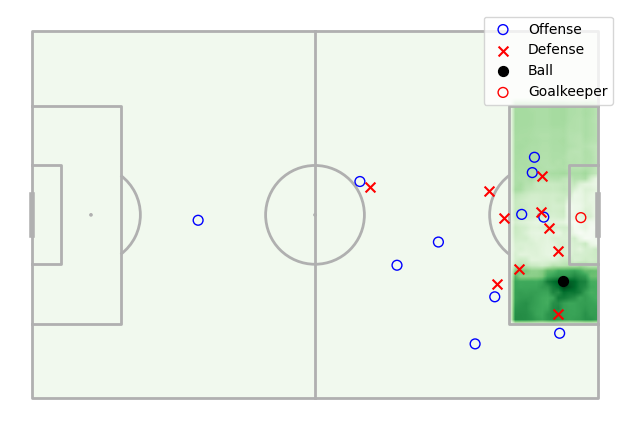

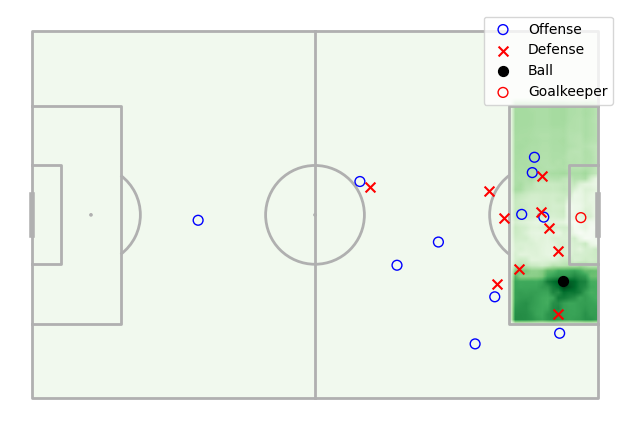

In [87]:
idx =(1836364, 46373)
surface = generate_gk_position_surface(idx, features, ball_ff, player_ff, model)
vf.plot_from_features(idx, player_ff,ball_ff, surface = surface)